In [153]:
# load ~32000 names from a file, one in each line
with open("names.txt", "r") as infile:
    words = infile.read().splitlines() # ignores \n

In [154]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [155]:
len(words)

32033

In [156]:
# ---------------- tensor instead of a dictionary ----------------

In [157]:
chars = sorted(set("".join(words) + "."))

In [158]:
ctoi = {c: i for i, c in enumerate(chars)}

In [159]:
itoc = {i: c for c, i in ctoi.items()}

In [160]:
# actually, it will be more convenient to keep these values in a 2D array (tensor/matrix)
import torch

In [162]:
contexts = []

for i in range(len(chars)):
    for j in range(len(chars)):
        contexts.append(chars[i] + chars[j])

In [163]:
ctxtoi = {ctx: i for i, ctx in enumerate(contexts)}

In [164]:
itoctx = {i: ctx for i, ctx in enumerate(ctxtoi)} # no .items() because i only need keys

In [348]:
N = torch.zeros((27 * 27, 27), dtype=torch.int32) # 26 letters + the special character

# create a 2D array with each cell corresponding to a particular trigram and its value being the number of occurrences
for w in words:
    # print(w)
    chars = ["."] * 2 + list(w) + ["."] * 1 # special start/end character x2 now, start is: ..s, end is e. (only one at the end!)
    # loop through characters in groups of 3
    for i in range(len(chars) - 2):
        ctx = "".join(chars[i:i+2])
        ch = chars[i+2]
        # print(f"{ctx}{ch}")
        idx1 = ctxtoi[ctx]
        idx2 = ctoi[ch]
        N[idx1][idx2] += 1

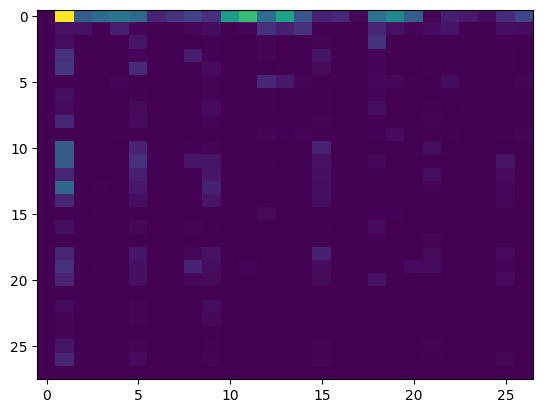

In [325]:
plt.imshow(N[:28], aspect="auto")

In [349]:
N[0], N[1], N[27], contexts[27] # raw counts

(tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929], dtype=torch.int32),
 tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
         623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
        dtype=torch.int32),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0], dtype=torch.int32),
 'a.')

In [328]:
N[0].shape, N.shape

(torch.Size([27]), torch.Size([729, 27]))

In [327]:
p = N[0].float() # probabilitity of a given character to start the word (N[0] is the starting char)
p /= p.sum() # normalize so that we get a distribution
p # sum of that is now 1

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [260]:
gen = torch.Generator().manual_seed(2147483647)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=gen).item() # "convert" probabilities (p) to ints
itoc[idx]

'.'

In [350]:
P = (N+1).float() # +1 for model smoothing (so that if there's no bigram, the cost won't explode to inf)
# 729x27 divided by 729x1
P /= P.sum(1, keepdim=True) # broadcasting, 1 says we want sums of rows (a column vector, 27x1), every P row gets divided by the row sum
P.shape

torch.Size([729, 27])

In [351]:
# actual sampling!
gen = torch.Generator().manual_seed(2147483647)

for i in range(20):
    name = []
    ctx = ".."
    while True:
        p = P[ctxtoi[ctx]]
        # choose a letter from a row containing trigrams starting with a given context
        # this row index then becomes index that we use for a column for the next letter
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=gen).item()
        
        name.append(itoc[idx]) # add a letter to the name (1st letter of a bigram)
        ctx = ctx[1:] + itoc[idx]
        if idx == 0: # special "." character
            break
    print("".join(name))

junide.
jakasid.
prelay.
adin.
kairritoper.
sathen.
sameia.
yanileniassibduinrwin.
lessiyanayla.
te.
farmumthyfortumj.
ponn.
lena.
jaylicore.
ya.
jocken.
jamilyn.
kmikim.
yah.
sanaasnhavi.


In [352]:
# log likelihood
n = 0
log_likelihood = 0.0

for w in words:
    chars = ["."] * 2 + list(w) + ["."] * 1 # special start/end character x2 now, start is: ..s, end is e..
    # loop through characters in groups of 3
    for i in range(len(chars) - 2):
        ctx = "".join(chars[i:i+2])
        ch = chars[i+2]
        idx1 = ctxtoi[ctx]
        idx2 = ctoi[ch]
        prob = P[idx1][idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ctx} {ch} prob: {prob:.4f} logprob: {logprob:.4f}")

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n
avg_nll.item(), n

(2.2119739055633545, 228146)

In [313]:
# 2 letter context - 2.4255354404449463
# 3 letter context - 2.2119739055633545 (1 dot at the end), 
# 2.092747449874878 (1 dot at the end and the start) -> "fake" loss i think -> no case of ..->a, ..->b etc. so the loss is lower
# but the generated words are actually the same or even worse because we choose the 1st letter randomly instead of what
# letter is the first letter in most cases (I think)
# 1.9262396097183228 (2 dots everywhere) -> "fake" loss -> any context like "x." is followed by "." so it's an easy loss decrease for
# but we gain no information from it, so samples are the same quality (check imshow N[27] when .. at the end for example!)
# also -> a. . prob: 1.0000 logprob: 0.0000, e. . prob: 1.0000 logprob: 0.0000 (with smoothening it's like 0.9960
# because of the +1 everywhere)
# quite an improvement!

In [353]:
# 2 . start
# junide.
# jakasid.
# prelay.
# adin.
# kairritoper.

# sathen.
# sameia.
# yanileniassibduinrwin.
# lessiyanayla.
# te.

# farmumthyfortumj.
# ponn.
# lena.
# jaylicore.
# ya.

# jocken.
# jamilyn.
# kmikim.
# yah.
# sanaasnhavi.

In [354]:
# 1 . start
# junide.
# ilyasid.
# prelay.
# ocin.
# fairritoper.

# sathen.
# dannaaryanileniassibduinrwin.
# lessiyanayla.
# te.
# farmumthyfortumj.

# ponn.
# zena.
# jaylicore.
# ya.
# zoffra.

# jamilyn.
# fmouis.
# yah.
# wanaasnhavi.
# honszxhddion.